# K-Means for Hearing Threshold Data Clustering: Older Adults Aged 60 or Above

`Each participant's both ears are treated as if they were two participants.`

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

import seaborn as sns
import numpy as np

In [23]:
# Load the data
file_path = "../../data/nhanes_1520_age.csv"
data = pd.read_csv(file_path)
data = data[data['RIDAGEYR'] >= 60]
data.set_index('SEQN', inplace=True)
print(data.shape)
data.head()

(2410, 15)


,AUXU500R,AUXU1K1R,AUXU2KR,AUXU3KR,AUXU4KR,AUXU6KR,AUXU8KR,AUXU500L,AUXU1K1L,AUXU2KL,AUXU3KL,AUXU4KL,AUXU6KL,AUXU8KL,RIDAGEYR
SEQN,,,,,,,,,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0,5.0,5.0,5.0,35.0,50.0,50.0,55.0,62
83754,10.0,20.0,10.0,10.0,20.0,25.0,40.0,10.0,15.0,5.0,10.0,15.0,30.0,25.0,67
83755,10.0,10.0,15.0,35.0,30.0,35.0,40.0,5.0,5.0,10.0,25.0,15.0,15.0,25.0,67
83775,55.0,60.0,50.0,50.0,50.0,70.0,75.0,65.0,60.0,50.0,60.0,65.0,75.0,65.0,69
83785,20.0,35.0,30.0,35.0,30.0,35.0,80.0,15.0,25.0,25.0,40.0,55.0,50.0,60.0,60


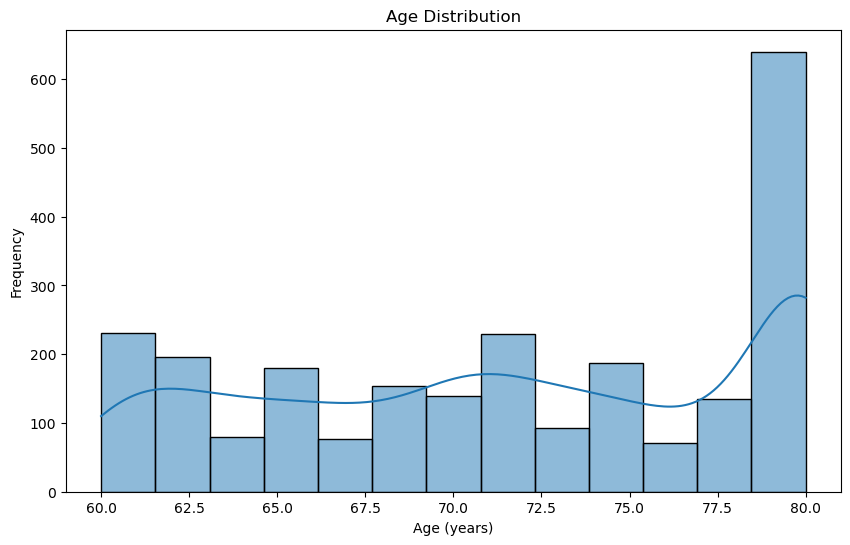

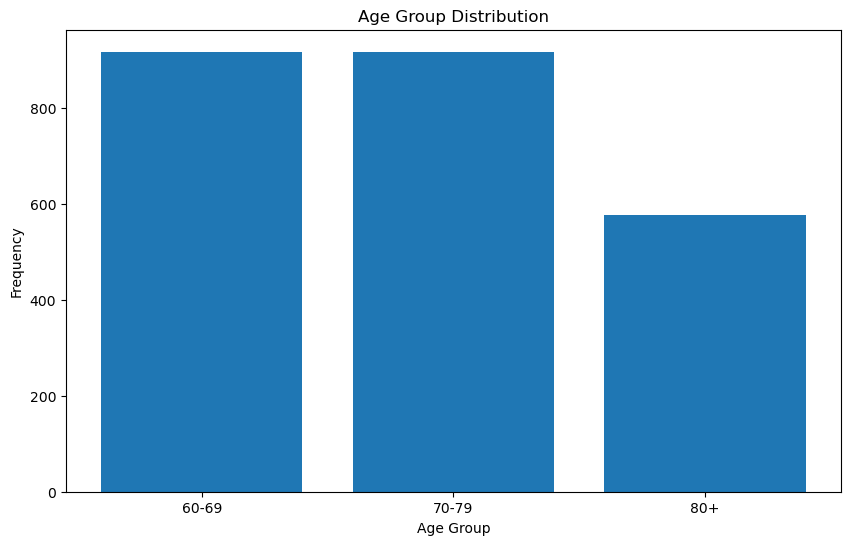

In [24]:
# Check the age distribution in the column 'RIDAGEYR'
plt.figure(figsize=(10, 6))
sns.histplot(data['RIDAGEYR'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

# Group age into 3 categories
data['age_group'] = pd.cut(data['RIDAGEYR'], bins=[60, 70, 80, 100], labels=['60-69', '70-79', '80+'], right = False)
data['age_group'].value_counts()

# Visualize the 3 categories
plt.figure(figsize=(10, 6))
plt.bar(data['age_group'].value_counts().index, data['age_group'].value_counts().values)
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.show()

In [25]:
# Select the columns for right ear measurements

right_ear_columns = ['AUXU500R', 'AUXU1K1R', 'AUXU2KR', 'AUXU3KR', 'AUXU4KR', 'AUXU6KR', 'AUXU8KR']
right_ear_data = data[right_ear_columns]
right_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']

# Select the columns for left ear measurements

left_ear_columns = ['AUXU500L', 'AUXU1K1L', 'AUXU2KL', 'AUXU3KL', 'AUXU4KL', 'AUXU6KL', 'AUXU8KL']
left_ear_data = data[left_ear_columns]
left_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']

# Concatenate the right and left ear data

ear_data = pd.concat([right_ear_data, left_ear_data], axis = 0)

# Change the column names to be more descriptive

ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83754,10.0,20.0,10.0,10.0,20.0,25.0,40.0
83755,10.0,10.0,15.0,35.0,30.0,35.0,40.0
83775,55.0,60.0,50.0,50.0,50.0,70.0,75.0
83785,20.0,35.0,30.0,35.0,30.0,35.0,80.0
...,...,...,...,...,...,...,...
124756,10.0,15.0,10.0,25.0,25.0,25.0,40.0
124784,45.0,50.0,50.0,50.0,50.0,45.0,80.0
124799,20.0,40.0,45.0,45.0,60.0,85.0,666.0


In [26]:
# Process missing values
cleaned_ear_data = ear_data.replace({888: np.nan, 666: np.nan, '.': np.nan}, inplace=False)
cleaned_ear_data = cleaned_ear_data.dropna(inplace=False)

# cleaned_ear_data.reset_index(drop=True, inplace=True)
cleaned_ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83754,10.0,20.0,10.0,10.0,20.0,25.0,40.0
83755,10.0,10.0,15.0,35.0,30.0,35.0,40.0
83775,55.0,60.0,50.0,50.0,50.0,70.0,75.0
83785,20.0,35.0,30.0,35.0,30.0,35.0,80.0
...,...,...,...,...,...,...,...
124750,20.0,5.0,15.0,30.0,40.0,40.0,35.0
124756,10.0,15.0,10.0,25.0,25.0,25.0,40.0
124784,45.0,50.0,50.0,50.0,50.0,45.0,80.0


In [27]:
# Define frequencies and their differences
frequencies = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']
freq_differences = [500, 1000, 1000, 1000, 2000, 2000]  # Differences between frequencies
local_slope_data = cleaned_ear_data.copy()
global_slope_data = cleaned_ear_data.copy()

# Compute the subsequent columns
for i in range(1, len(frequencies)):
    local_slope_data[frequencies[i]] = (cleaned_ear_data[frequencies[i]] - cleaned_ear_data[frequencies[i - 1]]) / freq_differences[i - 1]
    global_slope_data[frequencies[i]] = (cleaned_ear_data[frequencies[i]] - cleaned_ear_data[frequencies[0]]) / sum(freq_differences[:i])

# Define an inverse function to transform slope data back to the original scale
def local_slope_inverse_transform(data):
    for i in range(1, len(frequencies)):
        data[frequencies[i]] = data[frequencies[i]] * freq_differences[i - 1] + data[frequencies[i - 1]]
    return data

def global_slope_inverse_transform(data):
    data_inverse = data.copy()
    for i in range(1, len(frequencies)):
        data[frequencies[i]] = data[frequencies[i]] * sum(freq_differences[:i]) + data[frequencies[0]]
    return data

# Standardize the local slope data
local_scaler = StandardScaler()
local_slope_data_scaled = local_scaler.fit_transform(local_slope_data)
local_slope_data_scaled

array([[-0.63617703, -0.82079952, -0.6141301 , ...,  0.51165185,
        -0.86383892,  1.38541431],
       [-0.63617703,  0.89611464, -1.4540774 , ...,  0.51165185,
        -0.07680176,  0.59614798],
       [-0.63617703, -0.2484948 , -0.19415645, ..., -1.09992447,
        -0.07680176, -0.19311836],
       ...,
       [ 1.9906407 ,  0.32380992, -0.6141301 , ..., -0.56273237,
        -0.86383892,  2.17468064],
       [ 1.24012135, -0.82079952, -1.87405105, ..., -1.09992447,
         1.89079114, -0.19311836],
       [-1.01143671,  0.89611464, -0.6141301 , ..., -0.56273237,
         0.31671682,  0.59614798]])

In [28]:
# Standardize the global slope data
global_scaler = StandardScaler()
global_slope_data_scaled = global_scaler.fit_transform(global_slope_data)
global_slope_data_scaled

array([[-0.63617703, -0.82079952, -0.995623  , ..., -0.15443922,
        -0.70918685,  0.16758263],
       [-0.63617703,  0.89611464, -0.65189064, ..., -0.65998531,
        -0.70918685, -0.30817209],
       [-0.63617703, -0.2484948 , -0.30815828, ..., -0.15443922,
        -0.20373439, -0.30817209],
       ...,
       [ 1.9906407 ,  0.32380992, -0.30815828, ..., -0.91275836,
        -1.46736555, -0.07029473],
       [ 1.24012135, -0.82079952, -2.02682009, ..., -1.67107749,
        -0.45646062, -0.54604946],
       [-1.01143671,  0.89611464,  0.03557409, ...,  1.10942601,
         1.31262301,  1.59484682]])

In [29]:
# Standardize the data
standard_scaler = StandardScaler()
standard_scaled_data = standard_scaler.fit_transform(cleaned_ear_data)

# Min-max scaling
minmax_scaler = MinMaxScaler()
minmax_scaled_data = minmax_scaler.fit_transform(cleaned_ear_data)

# Robust scaling
## Note: Robust scaling is computed as (X - median) / IQR
robust_scaler = RobustScaler()
robust_scaled_data = robust_scaler.fit_transform(cleaned_ear_data)

# Quantile transformation
quantile_transformer = QuantileTransformer(output_distribution = 'normal')
quantile_transformed_data = quantile_transformer.fit_transform(cleaned_ear_data)

# K-Means with local slope data

KMeans with 2 clusters
Silhouette Score: 0.078
Davies Bouldin Score: 3.458
Calinski Harabasz Score: 260.789
-----------------------------------
KMeans with 3 clusters
Silhouette Score: 0.048
Davies Bouldin Score: 3.177
Calinski Harabasz Score: 270.047
-----------------------------------
KMeans with 4 clusters
Silhouette Score: 0.021
Davies Bouldin Score: 3.005
Calinski Harabasz Score: 388.752
-----------------------------------


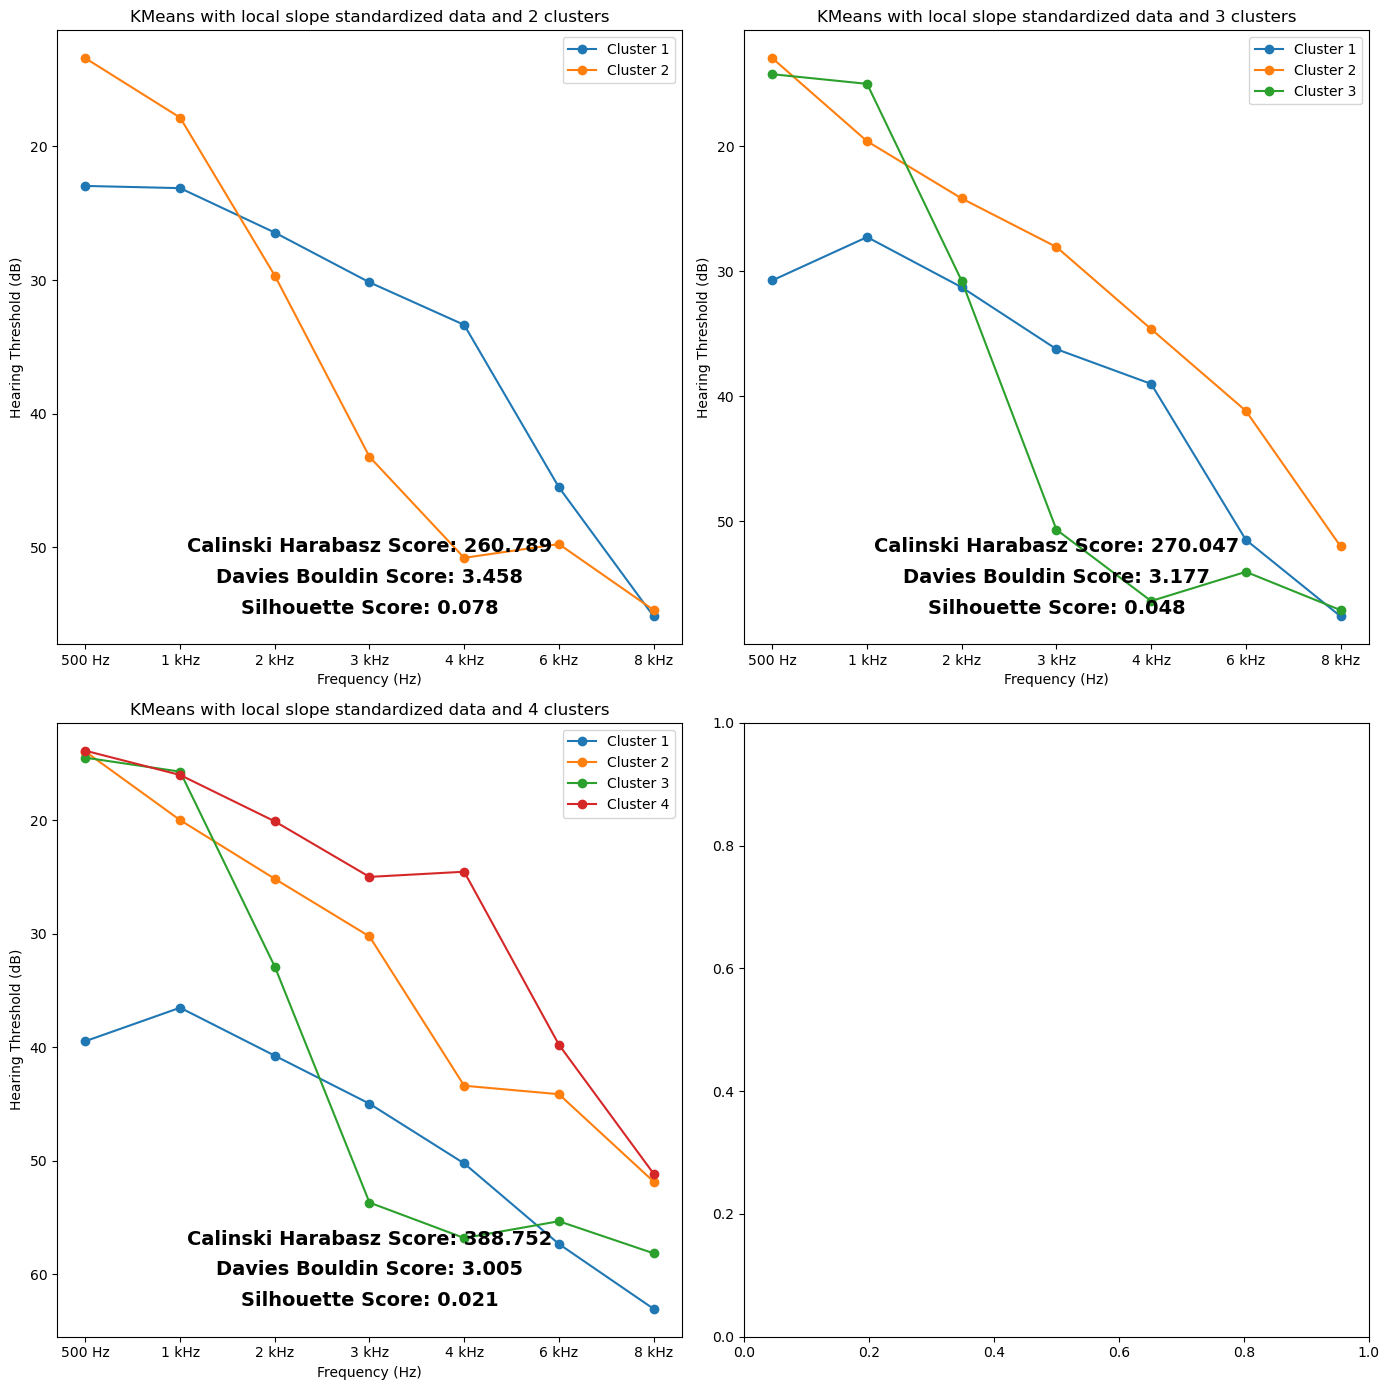

In [30]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14)) # Create a 2x2 grid of subplots

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(local_slope_data_scaled)

    # Extract the centroids
    ear_df = cleaned_ear_data.copy()
    ear_df['label'] = kmeans.labels_
    centroids = ear_df.groupby('label').mean()
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns,
            centroids_df.iloc[cluster_id],
            marker='o',
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with local slope standardized data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 35)

plt.tight_layout()
plt.show()

# K-Means with global slope data

KMeans with 2 clusters
Silhouette Score: 0.197
Davies Bouldin Score: 1.684
Calinski Harabasz Score: 1045.336
-----------------------------------
KMeans with 3 clusters
Silhouette Score: 0.060
Davies Bouldin Score: 2.802
Calinski Harabasz Score: 631.565
-----------------------------------
KMeans with 4 clusters
Silhouette Score: 0.113
Davies Bouldin Score: 2.478
Calinski Harabasz Score: 894.046
-----------------------------------


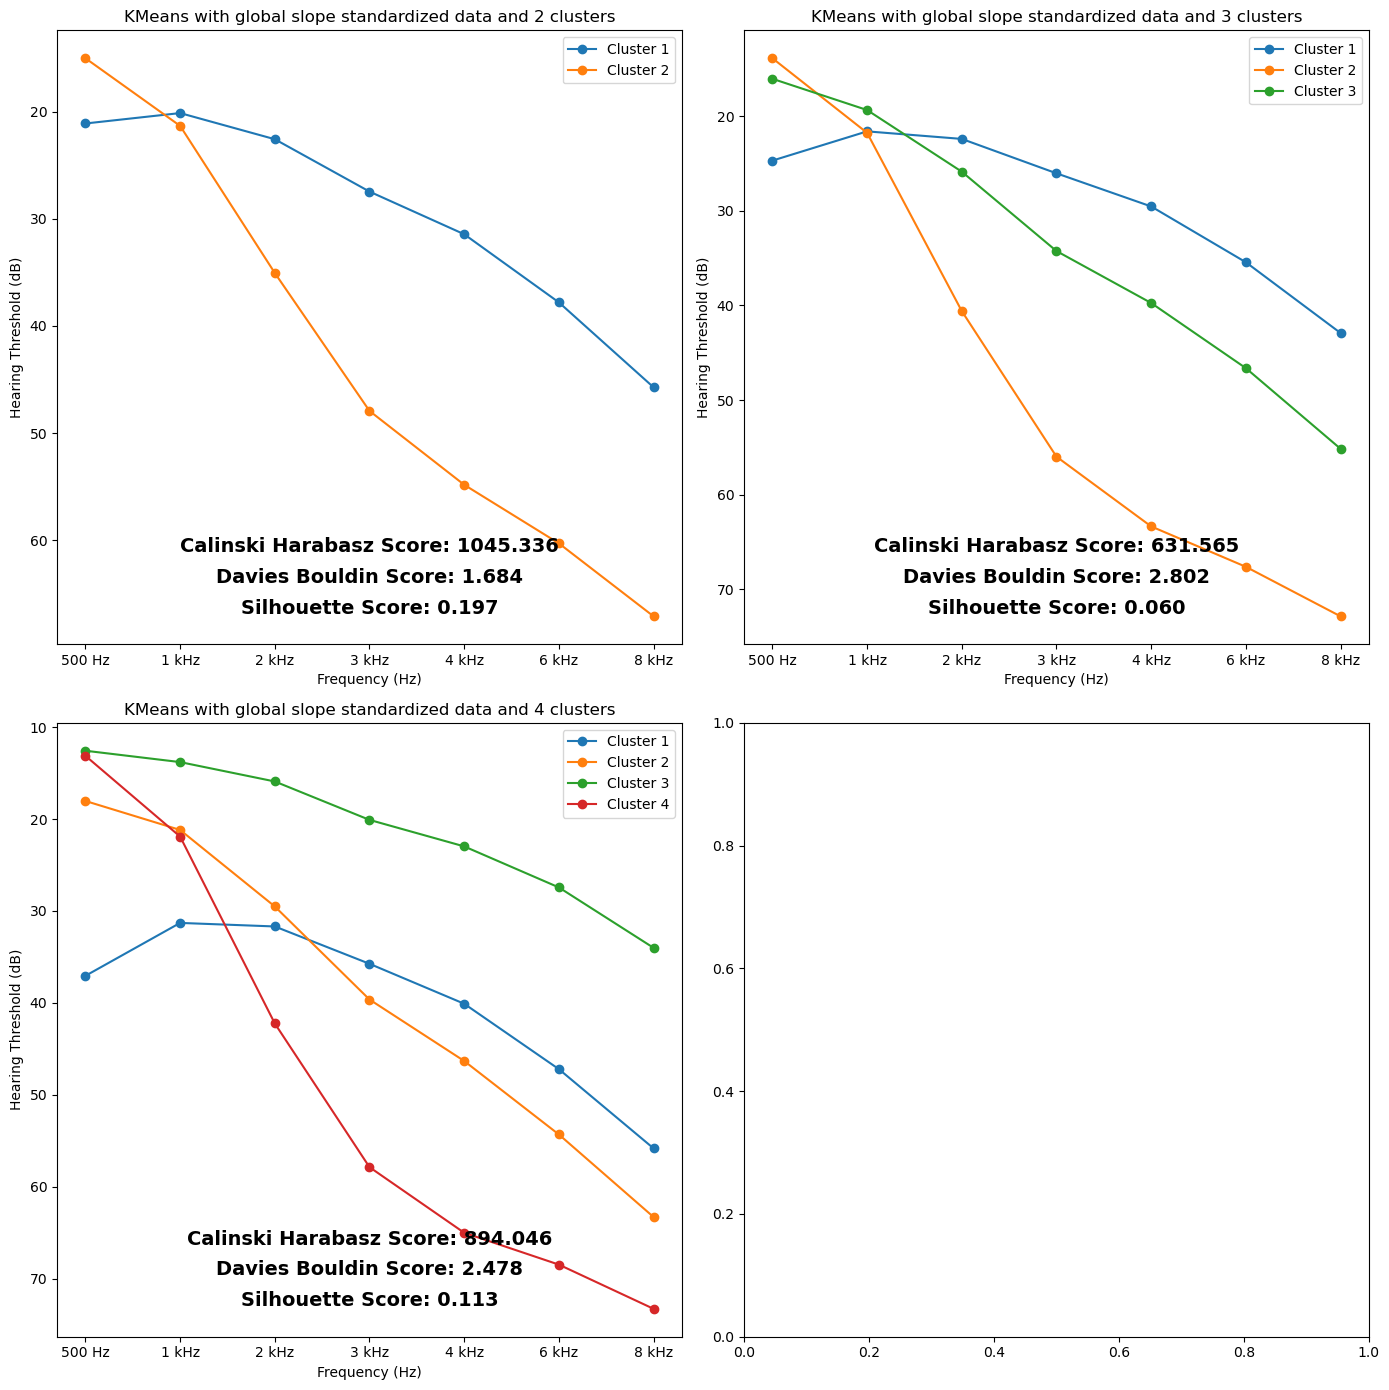

In [31]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14)) # Create a 2x2 grid of subplots

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(global_slope_data_scaled)

    # Extract the centroids
    ear_df = cleaned_ear_data.copy()
    ear_df['label'] = kmeans.labels_
    centroids = ear_df.groupby('label').mean()
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns,
            centroids_df.iloc[cluster_id],
            marker='o',
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with global slope standardized data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 35)

plt.tight_layout()
plt.show()